# Modelagem e Avaliação 

Neste tópico, iremos preparar nossos dados para modelagem, criando pipeline para garatir o correto pré-processamento dos nossos dados.Utilizaremos o modelo Árvore de decisão, um modelo que me sinto bastante confortável de usar por conhecer seu funcionamento e nuances. É um modelo não-linear, robusto a outliers e que não possui qualquer suposição sobre as distribuições, o que é algo bastante relevante, dado que a maioria dos dados na vida real apresentam não normalidade. Evitar a normalização é uma etapa a menos se você utiliza modelos baseados em árvore. 

## Dependências

In [3]:
# Bibliotecas
import os
import shap
import warnings
warnings.filterwarnings('ignore')
import cloudpickle
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import ShuffleSplit,learning_curve,RepeatedStratifiedKFold
from sklearn.preprocessing import FunctionTransformer
from utils.data_cleaning import normalizar_caracteres
from sklearn import set_config
from sklearn.inspection import permutation_importance
from utils.modelagem import calcular_metricas_threshold
from optuna.samplers import TPESampler
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

## Dados e Constantes

In [44]:
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_RAW_NAME = 'diabetes_data.csv'
DATA_INTER_PATH = os.path.join('..','data','inter')
DATA_INTER_TEST_NAME = 'diabetes_test.parquet'
DATA_INTER_TRAIN_NAME = 'diabetes_train.parquet'
DATA_INTER_TRAIN_FT_SELECTION = 'diabetes_train_selected.parquet'
PREDICT_PATH = os.path.join('..','data','output')
PREDICT_NAME = 'previsao_diagnostico.csv'
TRACKING_URI = 'http://localhost:5000/'
EXPERIMENT_NAME = 'diabetes_model'

In [45]:
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

2022/03/06 23:26:13 INFO mlflow.tracking.fluent: Experiment with name 'diabetes_model' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/bruno.santos/Desktop/Estudos/udacity/projeto_iris/mlruns/3', experiment_id='3', lifecycle_stage='active', name='diabetes_model', tags={}>

In [6]:
df_train_inter = pd.read_parquet(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_FT_SELECTION))
df_train= pd.read_parquet(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_NAME))

# Lendo dados de teste.
df_test = pd.read_parquet(os.path.join(DATA_INTER_PATH, DATA_INTER_TEST_NAME))

In [7]:
#Obtendo X e Y 
X = df_train.drop('target',axis=1)
y = df_train['target']

# Modelagem 

## Variáveis

In [8]:
#Separando as variáveis categóricas e numéricas
variaveis_numericas = ['idade']
variaveis_categoricas = list(set(df_train_inter.columns.tolist()).difference(set(variaveis_numericas)))


In [47]:
variaveis_categoricas

['polyuria',
 'perda_de_peso_repentina',
 'genero',
 'polyphagia',
 'polydipsia',
 'paresia_parcial']

In [9]:
variaveis_categoricas.remove('target')

In [10]:
X = X[variaveis_categoricas+variaveis_numericas]

## Criando pipeline

Aqui iremos criar um pipeline para tratar dados categóricos e outro para tratar nossos dados numéricos. Dessa maneira cada coluna é tratada da forma mais adequada. O resultado é combinado no final e passado para o classificador, último componente do pipeline.

In [11]:
#Pipeline numérico será tratado imputando a mediana
pipeline_numerico = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])
#Pipeline categórico será tratado com imputação através da moda e one hot encoder
pipeline_categorico = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                         ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore',drop='first'))])

In [12]:
#Column Transformer para unir os dois pipelines
preprocess_pipeline = ColumnTransformer([('pipeline_categorico', pipeline_categorico, variaveis_categoricas),
                                ('pipeline_numerico', pipeline_numerico, variaveis_numericas)])

In [13]:
#Definindo folds para a validação cruzada estratificada para garantir uma melhor distribuição do target.
cv = RepeatedStratifiedKFold(random_state=123, n_splits=10, n_repeats=10)

In [14]:
# Definindo modelo com random_seed e class_weight='balanced' para dar peso às classes mais raras
dt = DecisionTreeClassifier(random_state=123, class_weight='balanced')
# defninindo pipeline final, onde o último componente é o classificador
modelo_pipe =  Pipeline(steps =[('preprocessor',preprocess_pipeline),
                                  ('model_dt',dt)])

# Modelagem e Avaliação

## Otimização de Hiperparâmetros

Aqui utilizaremos otimização bayesiana para busca dos melhores hiperparâmetros para o classificador. Poderíamos ter utilizado o GridSearchCV ou o RandomizedSearchCV, porém esses seriam mais lentos. Vale salientar que a otimização está sendo feita em cima da média de validação cruzada para a log loss e que estamos utilizando RepeatedStratifiedKfold para garantir mesma proporção do target nos folds e também para termos uma melhor estimativa, uma vez que o dataset é pequeno.

In [15]:
def optimize_decision_tree(trial):
    "Optmization of Decision Tree Classifier"
# Grid de parametros otimizados
    params ={'model_dt__max_depth': trial.suggest_int('model_dt__max_depth',2,11),
          'model_dt__min_samples_leaf': trial.suggest_int('model_dt__min_samples_leaf',2,33),
          'model_dt__min_samples_split':trial.suggest_int('model_dt__min_samples_split',2,33)  }
    earlyStop=20
    modelo_pipe.set_params(**params)
    results = np.mean(cross_val_score(modelo_pipe,X,y, cv=cv, scoring = 'neg_log_loss'))
    print(f'LOG LOSS:{results}')
    return results

In [16]:
sampler = TPESampler(seed=123)  
study = optuna.create_study(sampler=sampler,direction='maximize')
study.optimize(optimize_decision_tree, n_trials=25)
print(study.best_trial)

[I 2022-03-06 22:09:07,542] A new study created in memory with name: no-name-9cef85db-b118-47cb-8ee8-eb4028c5628f
[I 2022-03-06 22:09:09,059] Trial 0 finished with value: -0.7538643650054415 and parameters: {'model_dt__max_depth': 8, 'model_dt__min_samples_leaf': 11, 'model_dt__min_samples_split': 9}. Best is trial 0 with value: -0.7538643650054415.


LOG LOSS:-0.7538643650054415


[I 2022-03-06 22:09:10,523] Trial 1 finished with value: -0.31705246095607315 and parameters: {'model_dt__max_depth': 7, 'model_dt__min_samples_leaf': 25, 'model_dt__min_samples_split': 15}. Best is trial 1 with value: -0.31705246095607315.


LOG LOSS:-0.31705246095607315


[I 2022-03-06 22:09:11,900] Trial 2 finished with value: -0.3432791221304196 and parameters: {'model_dt__max_depth': 11, 'model_dt__min_samples_leaf': 23, 'model_dt__min_samples_split': 17}. Best is trial 1 with value: -0.31705246095607315.


LOG LOSS:-0.3432791221304196


[I 2022-03-06 22:09:13,858] Trial 3 finished with value: -0.6201191570818547 and parameters: {'model_dt__max_depth': 5, 'model_dt__min_samples_leaf': 12, 'model_dt__min_samples_split': 25}. Best is trial 1 with value: -0.31705246095607315.


LOG LOSS:-0.6201191570818547


[I 2022-03-06 22:09:15,450] Trial 4 finished with value: -0.847916500254196 and parameters: {'model_dt__max_depth': 6, 'model_dt__min_samples_leaf': 3, 'model_dt__min_samples_split': 14}. Best is trial 1 with value: -0.31705246095607315.


LOG LOSS:-0.847916500254196


[I 2022-03-06 22:09:16,932] Trial 5 finished with value: -0.7972556373107609 and parameters: {'model_dt__max_depth': 9, 'model_dt__min_samples_leaf': 7, 'model_dt__min_samples_split': 7}. Best is trial 1 with value: -0.31705246095607315.


LOG LOSS:-0.7972556373107609


[I 2022-03-06 22:09:18,349] Trial 6 finished with value: -0.4897291716135123 and parameters: {'model_dt__max_depth': 7, 'model_dt__min_samples_leaf': 19, 'model_dt__min_samples_split': 22}. Best is trial 1 with value: -0.31705246095607315.


LOG LOSS:-0.4897291716135123


[I 2022-03-06 22:09:20,079] Trial 7 finished with value: -0.31705246095607315 and parameters: {'model_dt__max_depth': 10, 'model_dt__min_samples_leaf': 25, 'model_dt__min_samples_split': 21}. Best is trial 1 with value: -0.31705246095607315.


LOG LOSS:-0.31705246095607315


[I 2022-03-06 22:09:21,420] Trial 8 finished with value: -0.6690736066173169 and parameters: {'model_dt__max_depth': 9, 'model_dt__min_samples_leaf': 12, 'model_dt__min_samples_split': 13}. Best is trial 1 with value: -0.31705246095607315.


LOG LOSS:-0.6690736066173169


[I 2022-03-06 22:09:22,749] Trial 9 finished with value: -0.40600722595250055 and parameters: {'model_dt__max_depth': 4, 'model_dt__min_samples_leaf': 11, 'model_dt__min_samples_split': 22}. Best is trial 1 with value: -0.31705246095607315.


LOG LOSS:-0.40600722595250055


[I 2022-03-06 22:09:24,055] Trial 10 finished with value: -0.2800309167482243 and parameters: {'model_dt__max_depth': 2, 'model_dt__min_samples_leaf': 33, 'model_dt__min_samples_split': 33}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.2800309167482243


[I 2022-03-06 22:09:25,389] Trial 11 finished with value: -0.2800309167482243 and parameters: {'model_dt__max_depth': 2, 'model_dt__min_samples_leaf': 33, 'model_dt__min_samples_split': 32}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.2800309167482243


[I 2022-03-06 22:09:26,693] Trial 12 finished with value: -0.2800309167482243 and parameters: {'model_dt__max_depth': 2, 'model_dt__min_samples_leaf': 33, 'model_dt__min_samples_split': 33}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.2800309167482243


[I 2022-03-06 22:09:28,002] Trial 13 finished with value: -0.2800309167482243 and parameters: {'model_dt__max_depth': 2, 'model_dt__min_samples_leaf': 33, 'model_dt__min_samples_split': 32}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.2800309167482243


[I 2022-03-06 22:09:29,311] Trial 14 finished with value: -0.29028308580317047 and parameters: {'model_dt__max_depth': 3, 'model_dt__min_samples_leaf': 29, 'model_dt__min_samples_split': 28}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.29028308580317047


[I 2022-03-06 22:09:30,616] Trial 15 finished with value: -0.31208870112117343 and parameters: {'model_dt__max_depth': 4, 'model_dt__min_samples_leaf': 29, 'model_dt__min_samples_split': 2}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.31208870112117343


[I 2022-03-06 22:09:31,926] Trial 16 finished with value: -0.30988093060351724 and parameters: {'model_dt__max_depth': 3, 'model_dt__min_samples_leaf': 19, 'model_dt__min_samples_split': 28}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.30988093060351724


[I 2022-03-06 22:09:33,232] Trial 17 finished with value: -0.28652744373472877 and parameters: {'model_dt__max_depth': 2, 'model_dt__min_samples_leaf': 29, 'model_dt__min_samples_split': 29}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.28652744373472877


[I 2022-03-06 22:09:34,532] Trial 18 finished with value: -0.2900447026666912 and parameters: {'model_dt__max_depth': 5, 'model_dt__min_samples_leaf': 33, 'model_dt__min_samples_split': 33}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.2900447026666912


[I 2022-03-06 22:09:35,838] Trial 19 finished with value: -0.3123548303506977 and parameters: {'model_dt__max_depth': 3, 'model_dt__min_samples_leaf': 22, 'model_dt__min_samples_split': 25}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.3123548303506977


[I 2022-03-06 22:09:37,148] Trial 20 finished with value: -0.31164528099974886 and parameters: {'model_dt__max_depth': 4, 'model_dt__min_samples_leaf': 28, 'model_dt__min_samples_split': 30}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.31164528099974886


[I 2022-03-06 22:09:38,450] Trial 21 finished with value: -0.2800309167482243 and parameters: {'model_dt__max_depth': 2, 'model_dt__min_samples_leaf': 33, 'model_dt__min_samples_split': 32}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.2800309167482243


[I 2022-03-06 22:09:39,754] Trial 22 finished with value: -0.28652744373472877 and parameters: {'model_dt__max_depth': 2, 'model_dt__min_samples_leaf': 31, 'model_dt__min_samples_split': 26}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.28652744373472877


[I 2022-03-06 22:09:41,055] Trial 23 finished with value: -0.29034424965533573 and parameters: {'model_dt__max_depth': 3, 'model_dt__min_samples_leaf': 26, 'model_dt__min_samples_split': 31}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.29034424965533573


[I 2022-03-06 22:09:42,369] Trial 24 finished with value: -0.31257842205430775 and parameters: {'model_dt__max_depth': 5, 'model_dt__min_samples_leaf': 31, 'model_dt__min_samples_split': 31}. Best is trial 10 with value: -0.2800309167482243.


LOG LOSS:-0.31257842205430775
FrozenTrial(number=10, values=[-0.2800309167482243], datetime_start=datetime.datetime(2022, 3, 6, 22, 9, 22, 749644), datetime_complete=datetime.datetime(2022, 3, 6, 22, 9, 24, 55347), params={'model_dt__max_depth': 2, 'model_dt__min_samples_leaf': 33, 'model_dt__min_samples_split': 33}, distributions={'model_dt__max_depth': IntUniformDistribution(high=11, low=2, step=1), 'model_dt__min_samples_leaf': IntUniformDistribution(high=33, low=2, step=1), 'model_dt__min_samples_split': IntUniformDistribution(high=33, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=10, state=TrialState.COMPLETE, value=None)


In [17]:
print(f'O modelo obteve um score de validação cruzada para o log loss de: {study.best_value}')

O modelo obteve um score de validação cruzada para o log loss de: -0.2800309167482243


In [18]:
study.best_params

{'model_dt__max_depth': 2,
 'model_dt__min_samples_leaf': 33,
 'model_dt__min_samples_split': 33}

In [19]:
#Definindo os melhores hiperparâmetros, baseados na busca feita com a otimização bayesiana
modelo_pipe.set_params(**study.best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline_categorico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['polyuria',
                                                   'perda_de_peso_repentina',
                                                   'genero', 'polyphagia',
                                                   'polydipsia',
                                                   'paresia_parcial']),
                                                 ('pipeline_nume

In [20]:
# plotando o pipeline
set_config(display='diagram')
# Treinando o modelo
modelo_pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline_categorico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['polyuria',
                                                   'perda_de_peso_repentina',
                                                   'genero', 'polyphagia',
                                                   'polydipsia',
                                                   'paresia_parcial']),
                                                 ('pipeline_numerico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['idade'])])),
                ('model_dt',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                                        min_samples_leaf=33,
                                        min_samples_split=33,
                                        random_state=123))])

## Métricas

Em se tratando de diagnóstico de diabetes, acredito que a métrica recall é a mais importante, uma vez que se o paciente não for diagnósticado ele pode continuar tendo os mesmos comportamentos alimentares e agravar seu quadro, evoluindo para diabetes, por exemplo.

Isso posto, a cada threshold de classificação teremos um recall e , por isso, podemos plotar curvas com as métricas variando o threshold e observar seus valores.

In [22]:
df_metrics = calcular_metricas_threshold(y, modelo_pipe.predict_proba(X)[:,1])

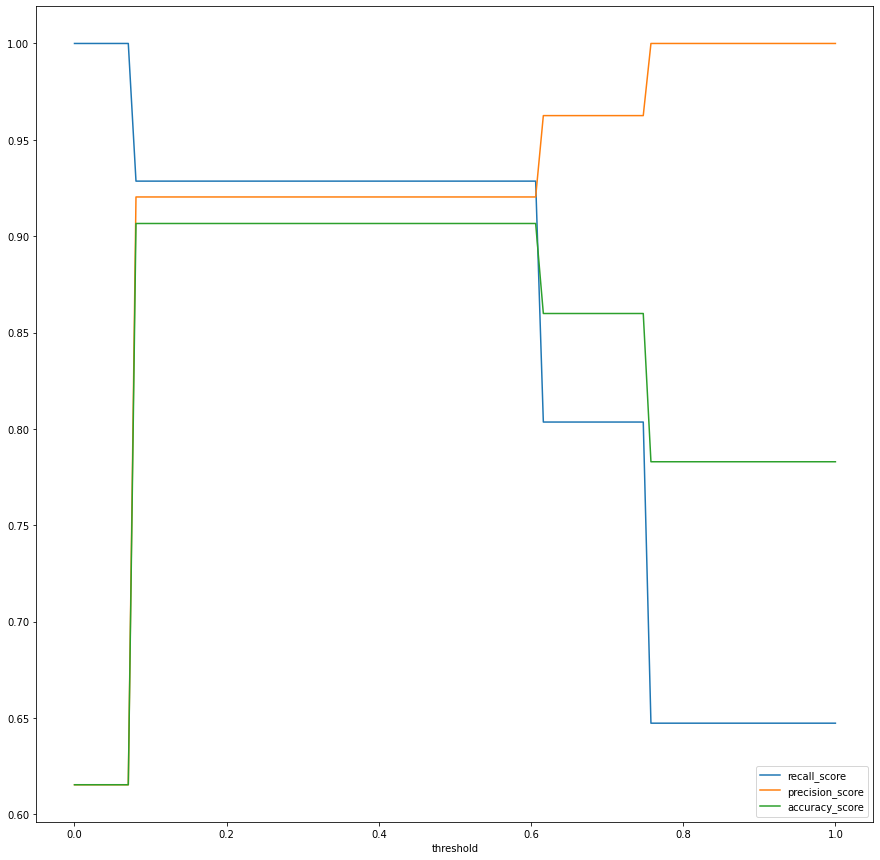

In [23]:
df_metrics.plot(x='threshold', figsize=(15,15))
plt.show()

É possível descobrir o threshold ideal, o que maximiza o recall e ao mesmo tempo não deteriora outras métricas como precision. O precision, nesse caso, se refere a taxa de pessoas diagnosticadas corretamente, ou podemos pensar nela como sendo uma taxa de alarme falso. Junto a equipe médica seria decidido qual métrica realmente é a mais importante e que nível de erro se deseja ter para as outras métricas.

Além disso, existe ainda a possibilidade de usarmos a probabilidade como resultado do modelo. Dessa forma, cada paciente receberia um score de 0 a 1, no qual o quanto mais próximo de 1, mais provável do paciente estar em estágio inicial de diabetes.

Como precisamos de uma métrica para verificar overfitting, escolheremos a curva ROC, pois esta não depende de threshold e sumariza bem o modelo, uma vez que traz a probabilidade de uma instância aleatória positiva receber uma probabiliade maior que uma instância aleatória positiva.

In [40]:
# Área da Curva ROC
roc_auc_score_train = roc_auc_score(y, modelo_pipe.predict_proba(X)[:,1])
roc_auc_score_train

0.9446269132653061

A área da curva ROC está bastante elevada no dataset de treino. Vamos checar se isso se sustenta também no teste.

## Dados de teste

Agora que já treinamos o modelo e definimos os hiperparâmetros que maximizam nossa métrica, iremos comparar a perfomance do treino com a de teste.

Mas primeiro, iremos adicionar um passo ao nosso pipeline, o qual necessita de uma operação para normalizar os caracteres. Vamos construir um FunctionTransformer e integrá-lo ao pipeline.

In [25]:
def normalizar_caracteres(df: pd.DataFrame) -> pd.DataFrame:
    """Torna os caracteres de uma string minúsculos.

    Args:
        lista_variaveis_categoricas (list): Lista com as variáveis categóricas (strings)
                                             para serem transformadas.
        df (DataFrame): Dataframe para ser analisado.

    Returns:
        df: Dataframe transformado.
    """
    for col in df.columns:
        df[col] = df[col].str.lower()
    return df
char_normalizer = FunctionTransformer(normalizar_caracteres)

In [26]:
#Pipeline numérico será tratado imputando a mediana
pipeline_numerico = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])
#Pipeline categórico será tratado com imputação através da moda e one hot encoder
pipeline_categorico = Pipeline(steps=[('char_normalizer', char_normalizer),
                         ('impute', SimpleImputer(strategy='most_frequent')),
                         ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore',drop='first'))])
# Column Transformer para unir os dois pipelines
preprocess_pipeline = ColumnTransformer([('pipeline_categorico', pipeline_categorico, variaveis_categoricas),
                                ('pipeline_numerico', pipeline_numerico, variaveis_numericas)])
modelo_pipe =  Pipeline(steps =[('preprocessor',preprocess_pipeline),
                                  ('model_dt',dt)])
modelo_pipe.set_params(**study.best_params)
modelo_pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline_categorico',
                                                  Pipeline(steps=[('char_normalizer',
                                                                   FunctionTransformer(func=<function normalizar_caracteres at 0x14a106e50>)),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['polyuria',
                                                   'perda_de_peso_repentina',
                                                   'genero', 'polyphagia',
                                                   'polydipsia',
                                                   'paresia_parcial']),
                                                 ('pipeline_numerico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['idade'])])),
                ('model_dt',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                                        min_samples_leaf=33,
                                        min_samples_split=33,
                                        random_state=123))])

Primeiro vamos avaliar no dataset inteiro (com duplicatas) e depois sem duplicatas.

In [27]:
y_test = df_test['target']
X_test = df_test[variaveis_categoricas+variaveis_numericas]

In [28]:
y_pred_test_proba = modelo_pipe.predict_proba(X_test)

In [29]:
roc_auc_score_teste = roc_auc_score(y_test, y_pred_test_proba[:,1])
print(f'O modelo obteve um score de teste para o recall de: {roc_auc_score_teste}')

O modelo obteve um score de teste para o recall de: 0.8440972222222223


In [30]:
df_test_deduplicated = df_test.drop_duplicates()
y_test_deduplicated = df_test_deduplicated['target']
X_test_deduplicated = df_test_deduplicated[variaveis_categoricas+variaveis_numericas]
y_pred_test_proba_deduplicated = modelo_pipe.predict_proba(X_test_deduplicated)

In [31]:
roc_auc_score_teste_deduplicated = roc_auc_score(y_test_deduplicated, y_pred_test_proba_deduplicated[:,1])
print(f'O modelo obteve um score de teste para o recall de: {roc_auc_score_teste_deduplicated}')

O modelo obteve um score de teste para o recall de: 0.829861111111111


Vemos que as duplicatas no set de test tornam a estimativa de performance um pouco mais otimista. No geral, o descréscimo em relação a métrica de treino foi de 13%. Não necessariamente significa um overfitting. Mas a grid de parâmetros pode ser melhor estudada, a fim de aproximar mais a métrica de treino e teste do modelo.

## SHAP

Para interpretar o modelo existem diversas técnicas. O Decision Tree, modelo utilizado, nos informa o Feature Importance, porém essa é uma técnica que pode ter algum viés, principalmente quando há presença de variáveis categóricas. Outra técnica rica é o Permutation Importance, que avalia a importância das features medindo a queda de performance quando esta é retirada. Nesse trabalho irei trazer o método de shap values, que é agnóstico a modelo e é baseado na teoria dos jogos.

A análise se interpretabilidade se fez necessário para responder a questão de forma mais segura: 

- Quais os 3 principais fatores que levam a um diagnóstico positivo de diabetes?

In [34]:
X_A1_test = df_test[variaveis_categoricas+variaveis_numericas]
X_A1 = df_train[variaveis_categoricas+variaveis_numericas]

In [35]:
X_A1_test_shap = pd.DataFrame(modelo_pipe['preprocessor'].transform(X_A1_test), columns = variaveis_categoricas+variaveis_numericas)

In [36]:
explainer_dt = shap.TreeExplainer(modelo_pipe['model_dt'])
shap_values = explainer_dt.shap_values(X_A1_test_shap, check_additivity=False)

## Quais os 3 principais fatores que levam a um diagnóstico positivo de diabetes?


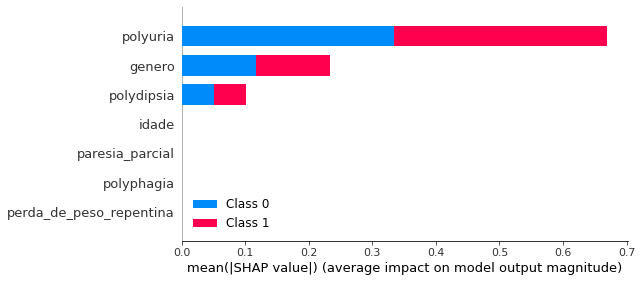

In [37]:
shap.summary_plot(shap_values,features=X_A1_test_shap, feature_names=X_A1_test_shap.columns,)

Com base, no feature importance e summary_plot as variáveis que apresentaram uma melhor relação para prever o diabetes, são: polyuria, genero e polydpsia. Note que estas variáveis dominam a resposta do modelo, talvez só com essas já atinjamos um resultado razoável.

# Logs Mlflow

In [46]:
with mlflow.start_run():
    mlflow.set_tag('step','Experimentation')
    mlflow.log_metrics({'roc_auc_train':roc_auc_score_train, 
                        'roc_auc_test':roc_auc_score_teste, 
                        'roc_auc_test_deduplicated':roc_auc_score_teste_deduplicated})
    mlflow.log_params(study.best_params)
    mlflow.sklearn.log_model(modelo_pipe, artifact_path='model')